In [1]:
import numpy as np
import pandas as pd
import itertools
import io
import timeit
import matplotlib.pyplot as plt

from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
#%tensorflow_version 2.x
#import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"1rJUCyDztqA321Uo690atZCQYS8Q1Y6XN"})
downloaded.GetContentFile('preprocessed_data.csv')
data_ready = pd.read_csv('preprocessed_data.csv')

In [ ]:
par = ['Batch size', 'Dropout rate', 'L2 reg', 'Num layers']
val = ['512, 2048, 4096', '0, 0.3', '0, 0.1', '1, 5, 10']

d = {'Parametro': par, 'Valori possibili': val}
hyperp_grid = pd.DataFrame(d)

hyperp_grid.to_csv('hyperp_grid.csv', encoding = 'utf-8-sig') 
files.download('hyperp_grid.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
def create_nn_model(dropout_rate=0.0, lam_l2=1e-3, learn_rate=1e-3, nlayers=5, nclass=3):
    # create model
    model = Sequential(name="Neural_network")
    for i in range(nlayers):
        model.add(layers.Dense(8*(nlayers-i), kernel_regularizer=l2(lam_l2), bias_regularizer=l2(lam_l2), input_dim=input_dim, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(nclass, activation='softmax'))
    optimizer = keras.optimizers.Adam(learn_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def plot_history(history, name = 'provah'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x[:-1], acc[1:], 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x[:-1], loss[1:], 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    filename = name + '.png'
    plt.savefig(filename, bbox_inches = 'tight')

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', xsize=4, ysize=3,
                          cmap=None, normalize=True, name='prova'):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(xsize, ysize))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
  #  plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    filename = name + '.png'
    plt.savefig(filename, bbox_inches = 'tight')

In [ ]:
# define the grid search parameters
#batch_size
cand_bs = [512, 2048, 4096]
#dropout rate
cand_dr = [0, 0.3]
#regularization
cand_l2 = [0, 1e-1]
#learning rate
#cand_lr = [1e-4, 1e-3, 1e-2]
#layers number
cand_ln = [10, 5, 1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  del sys.path[0]


In [5]:
#print(data_ready['category'].value_counts())
cat_index = data_ready['category'].value_counts().index

In [6]:
select_data = data_ready[data_ready['category'].isin(cat_index[0:3])].dropna().reset_index(drop=True)
print(select_data['category'].value_counts())

#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(select_data["clean_text"], select_data["category"], random_state = 1000,
                                                    stratify = select_data["category"], test_size=0.2, shuffle=True)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train = tfidf_vectorizer.fit_transform(X_train) 
X_test = tfidf_vectorizer.transform(X_test)

X_train.sort_indices()
X_test.sort_indices()

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = to_categorical(encoded_y_train)
dummy_y_test = to_categorical(encoded_y_test)

input_dim = X_train.shape[1]  # Number of features

X_train0 = X_train
dummy_y_train0 = dummy_y_train
X_test0 = X_test
dummy_y_test0 = dummy_y_test
encoded_y_test0 = encoded_y_test

model = KerasClassifier(build_fn=create_nn_model, epochs=25, verbose=0, nclass=3)

hep-ph      50603
quant-ph    44678
hep-th      39013
Name: category, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Tune hyperparameters through cross-validation

In [ ]:
#1 hidden layer

param_grid = dict(batch_size=cand_bs, dropout_rate=cand_dr, lam_l2=cand_l2, nlayers=cand_ln[2:3])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose = 3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best with 1 hidden layer: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results0 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

In [ ]:
#5 hidden layers

param_grid = dict(batch_size=cand_bs, dropout_rate=cand_dr, lam_l2=cand_l2, nlayers=cand_ln[1:2])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose = 3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best with 5 hidden layers: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results1 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

In [ ]:
#10 hidden layers

param_grid = dict(batch_size=cand_bs, dropout_rate=cand_dr, lam_l2=cand_l2, nlayers=cand_ln[0:1])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose = 3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best with 10 hidden layers: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results2 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

Summarizing results

In [ ]:
cv_results = pd.concat([cv_results0, cv_results1, cv_results2]).sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
cv_results.drop(['std_fit_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 
                 'split2_test_score', 'split3_test_score', 'split4_test_score'], 1, inplace = True)
clist = list(cv_results.columns.values)
cv_results_set0_nn = cv_results[clist[-2:] + clist[:-2]]
cv_results_set0_nn.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,mean_test_score,std_test_score,mean_fit_time,mean_score_time,param_batch_size,param_dropout_rate,param_lam_l2,param_nlayers
0,0.952874,0.001265,19.606653,0.304203,2048,0,0,1
1,0.952306,0.000999,30.247239,0.404164,512,0.3,0,1
2,0.952138,0.001662,19.316914,0.307041,2048,0.3,0,1
3,0.949970,0.001091,17.742523,0.295999,4096,0,0,1
4,0.949691,0.001238,17.625663,0.291132,4096,0.3,0,1
5,0.949458,0.001305,31.011815,0.407232,512,0,0,1
6,0.948024,0.000967,20.128936,0.366224,4096,0.3,0,5
7,0.947494,0.000751,21.458816,0.370651,2048,0.3,0,5
8,0.946442,0.000590,33.377254,0.460079,512,0.3,0,5
9,0.942626,0.001271,38.406523,0.533708,512,0,0,10


In [ ]:
cv_results_set0_nn.to_csv('cv_results_set0_nn.csv', encoding = 'utf-8-sig') 
files.download('cv_results_set0_nn.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training the best model on the whole training set

In [7]:
clear_session()

model = create_nn_model(dropout_rate=0, lam_l2=0, learn_rate=1e-3, nlayers=1)
model.summary()

Model: "Neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 373752    
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 373,779
Trainable params: 373,779
Non-trainable params: 0
_________________________________________________________________


In [ ]:
h0 = model.fit(X_train, dummy_y_train, epochs=50, verbose=True,
                    validation_data=(X_test, dummy_y_test), batch_size=2048)

In [9]:
idx_min_test_loss0 = np.argmin(h0.history['val_loss'])
best_acc0 = h0.history['val_accuracy'][idx_min_test_loss0]

loss, accuracy = model.evaluate(X_train0, dummy_y_train0, verbose=False)
print("Training Accuracy: {:.3f}".format(accuracy))
loss, accuracy = model.evaluate(X_test0, dummy_y_test0, verbose=False)
print("Testing Accuracy: {:.3f}".format(accuracy))

print("Minimum value of loss in the test set at epoch: {:d}".format(idx_min_test_loss0))
print("Testing Accuracy at that epoch: {:.3f}".format(best_acc0))

Training Accuracy: 0.985
Testing Accuracy: 0.952
Minimum value of loss in the test set at epoch: 28
Testing Accuracy at that epoch: 0.954


In [ ]:
plt.style.use('ggplot')
   
plot_history(h0, name = 'hnn0')

In [10]:
test_predicted_prob0 = model.predict(X_test0)
test_predicted_classes0 = test_predicted_prob0.argmax(1)

In [11]:
encoded_y_test0

array([1, 1, 1, ..., 1, 1, 2])

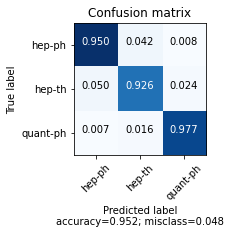

In [12]:
#Confusion matrix
conf = confusion_matrix(encoded_y_test0, test_predicted_classes0)
le_name_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
class_codes = [le_name_mapping[i] for i in range(3)]
plot_confusion_matrix(conf, class_codes, name = 'nn0')

Set 1

In [13]:
select_data = data_ready[data_ready['category'].isin(cat_index[4:9])].reset_index(drop=True)
print(select_data['category'].value_counts())

#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(select_data["clean_text"], select_data["category"], random_state = 1000,
                                                    stratify = select_data["category"], test_size=0.2, shuffle=True)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train = tfidf_vectorizer.fit_transform(X_train) 
X_test = tfidf_vectorizer.transform(X_test)

X_train.sort_indices()
X_test.sort_indices()

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = to_categorical(encoded_y_train)
dummy_y_test = to_categorical(encoded_y_test)

input_dim = X_train.shape[1]  # Number of features

X_train1 = X_train
dummy_y_train1 = dummy_y_train
X_test1 = X_test
dummy_y_test1 = dummy_y_test
encoded_y_test1 = encoded_y_test

model = KerasClassifier(build_fn=create_nn_model, epochs=25, verbose=0, nclass=5)

stat       19868
math-ph    17597
nucl-th    13730
q-bio      13316
hep-ex     10158
Name: category, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
#1 hidden layer

param_grid = dict(batch_size=cand_bs, dropout_rate=cand_dr, lam_l2=cand_l2, nlayers=cand_ln[2:3])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose = 3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best with 1 hidden layer: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results0 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

In [ ]:
#5 hidden layers

param_grid = dict(batch_size=cand_bs, dropout_rate=cand_dr, lam_l2=cand_l2, nlayers=cand_ln[1:2])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose = 3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best with 5 hidden layers: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results1 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

In [ ]:
#10 hidden layers

param_grid = dict(batch_size=cand_bs, dropout_rate=cand_dr, lam_l2=cand_l2, nlayers=cand_ln[0:1])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose = 3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best with 10 hidden layers: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results2 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

In [ ]:
cv_results = pd.concat([cv_results0, cv_results1, cv_results2]).sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)
cv_results.drop(['std_fit_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 
                 'split2_test_score', 'split3_test_score', 'split4_test_score'], 1, inplace = True)
clist = list(cv_results.columns.values)
cv_results_set1_nn = cv_results[clist[-2:] + clist[:-2]]
cv_results_set1_nn.head(10)

In [ ]:
cv_results_set1_nn.to_csv('cv_results_set1_nn.csv', encoding = 'utf-8-sig') 
files.download('cv_results_set1_nn.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
clear_session()

model = create_nn_model(dropout_rate=0.3, lam_l2=0, learn_rate=1e-3, nlayers=1, nclass=5)
model.summary()

Model: "Neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 491336    
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
Total params: 491,381
Trainable params: 491,381
Non-trainable params: 0
_________________________________________________________________


In [15]:
h1 = model.fit(X_train, dummy_y_train, epochs=50, verbose=True,
                    validation_data=(X_test, dummy_y_test), batch_size=512)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/Neural_network/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/Neural_network/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 8), dtype=float32), dense_shape=Tensor("gradient_tape/Neural_network/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


117/117 [==============================] - 2s 13ms/step - loss: 1.3708 - accuracy: 0.6168 - val_loss: 1.0899 - val_accuracy: 0.7973
Epoch 2/50
117/117 [==============================] - 2s 15ms/step - loss: 0.9311 - accuracy: 0.7591 - val_loss: 0.6708 - val_accuracy: 0.9260
Epoch 3/50
117/117 [==============================] - 2s 16ms/step - loss: 0.6684 - accuracy: 0.8118 - val_loss: 0.4525 - val_accuracy: 0.9405
Epoch 4/50
117/117 [==============================] - 2s 11ms/step - loss: 0.5413 - accuracy: 0.8343 - val_loss: 0.3405 - val_accuracy: 0.9469
Epoch 5/50
117/117 [==============================] - 2s 11ms/step - loss: 0.4660 - accuracy: 0.8515 - val_loss: 0.2763 - val_accuracy: 0.9502
Epoch 6/50
117/117 [==============================] - 2s 11ms/step - loss: 0.4164 - accuracy: 0.8638 - val_loss: 0.2352 - val_accuracy: 0.9531
Epoch 7/50
117/117 [==============================] - 2s 11ms/step - loss: 0.3839 - accuracy: 0.8739 - val_loss: 0.2067 - val_accuracy: 0.9549
Epoch 8/50

In [16]:
idx_min_test_loss1 = np.argmin(h1.history['val_loss'])
best_acc1 = h1.history['val_accuracy'][idx_min_test_loss1]

loss, accuracy = model.evaluate(X_train1, dummy_y_train1, verbose=False)
print("Training Accuracy: {:.3f}".format(accuracy))
loss, accuracy = model.evaluate(X_test1, dummy_y_test1, verbose=False)
print("Testing Accuracy: {:.3f}".format(accuracy))

print("Minimum value of loss in the test set at epoch: {:d}".format(idx_min_test_loss0))
print("Testing Accuracy at that epoch: {:.3f}".format(best_acc0))

Training Accuracy: 0.998
Testing Accuracy: 0.960
Minimum value of loss in the test set at epoch: 28
Testing Accuracy at that epoch: 0.954


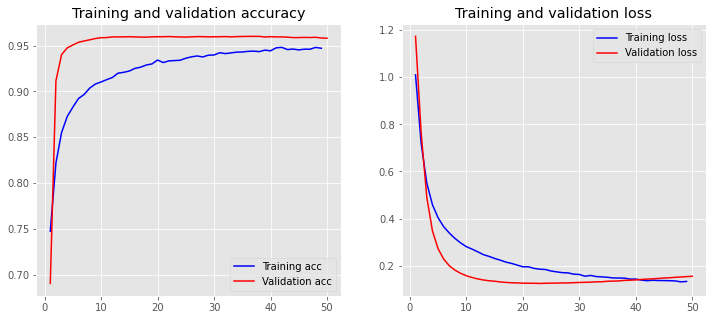

In [ ]:
plt.style.use('ggplot')
   
plot_history(h1, name="hnn1")

In [18]:
test_predicted_prob1 = model.predict(X_test1)
test_predicted_classes1 = test_predicted_prob1.argmax(1)

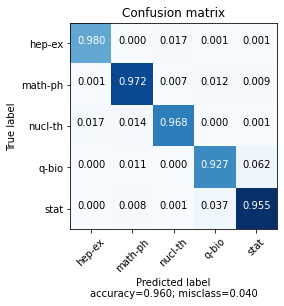

In [19]:
#Confusion matrix
conf = confusion_matrix(encoded_y_test1, test_predicted_classes1)
le_name_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
class_codes = [le_name_mapping[i] for i in range(5)]
plot_confusion_matrix(conf, class_codes, name = 'nn1', xsize=6, ysize=4)